In [94]:
import numpy as np
import matplotlib.pyplot as plt
import numbers # For integer type checking
from typing import Sequence, Tuple, Optional, List, Union, Any, Dict
from itertools import product
from mpl_toolkits.mplot3d import Axes3D # For 3D plots

In [159]:


class Lattice:
    """
    Represents a crystal lattice defined by primitive vectors and supercell dimensions.

    Generates coordinates, provides visualization, and neighbor finding capabilities
    with periodic boundary conditions. Neighbor finding results are cached.

    Attributes:
        primitive_vectors (np.ndarray): (dim x dim) array of primitive vectors (rows).
        supercell_dims (np.ndarray): (dim,) array of supercell dimensions.
        dim (int): Spatial dimension.
        num_sites (int): Total number of sites in the supercell.
        site_coordinates (np.ndarray): (num_sites x dim) array of site coordinates (property).
    """

    def __init__(self, primitive_vectors: np.ndarray, supercell_dims: Sequence[int]):
        """
        Initializes the Lattice object.

        Args:
            primitive_vectors: (dim x dim) array-like primitive vectors.
            supercell_dims: (dim,) sequence of positive integer dimensions.

        Raises:
            ValueError: If inputs are invalid or dimensions mismatch.
            np.linalg.LinAlgError: If primitive vectors form a singular matrix.
        """
        # --- Input Validation ---
        try:
            _prim_vecs = np.array(primitive_vectors, dtype=float)
        except Exception as e:
            raise ValueError(f"Invalid primitive_vectors: {e}")

        if _prim_vecs.ndim != 2 or _prim_vecs.shape[0] != _prim_vecs.shape[1]:
            raise ValueError(f"primitive_vectors must be a square (dim x dim) matrix, got shape {_prim_vecs.shape}")

        self._dim: int = _prim_vecs.shape[0]

        try:
            _sc_dims = np.array(supercell_dims, dtype=int)
        except Exception as e:
            raise ValueError(f"Invalid supercell_dims: {e}")

        if _sc_dims.ndim != 1 or len(_sc_dims) != self.dim:
            raise ValueError(f"supercell_dims must be 1D with length {self.dim}, got shape {_sc_dims.shape}")

        if np.any(_sc_dims <= 0):
            raise ValueError(f"supercell_dims must all be positive integers, got {_sc_dims}")

        # --- Store Validated Inputs ---
        self.primitive_vectors: np.ndarray = _prim_vecs
        self.supercell_dims: np.ndarray = _sc_dims
        self._num_sites: int = np.prod(self.supercell_dims)

        # --- Pre-computation for Methods ---
        try:
            # Needed for get_fractional_coordinates
            self._inv_prim_vecs_T = np.linalg.inv(self.primitive_vectors.T)
        except np.linalg.LinAlgError:
             # Check determinant for a clearer error message if singular
            det = np.linalg.det(self.primitive_vectors)
            if np.isclose(det, 0):
                raise np.linalg.LinAlgError("Primitive vectors form a singular matrix (determinant is zero).")
            else: # Should not happen if det!=0, but include for completeness
                raise np.linalg.LinAlgError("Could not compute inverse of primitive vectors matrix transpose.")

        # Needed for PBC calculations (visualize, find_neighbors)
        self._supercell_vectors = self.primitive_vectors * self.supercell_dims[:, np.newaxis]

        # --- Generate Coordinates ---
        self._site_coordinates: np.ndarray = self._generate_coordinates()

        # --- Initialize Neighbor Cache ---
        self._neighbor_cache: Dict[Tuple[int, float], Tuple[np.ndarray, np.ndarray]] = {}


    # --- Public Properties ---
    @property
    def dim(self) -> int:
        """The spatial dimension of the lattice."""
        return self._dim

    @property
    def num_sites(self) -> int:
        """The total number of lattice sites in the supercell."""
        return self._num_sites

    @property
    def site_coordinates(self) -> np.ndarray:
        """A (num_sites x dim) numpy array of site coordinates (returns a copy)."""
        return self._site_coordinates.copy()

    # --- Coordinate Generation ---
    def _generate_coordinates(self) -> np.ndarray:
        """Generates coordinates R = n1*a1 + n2*a2 + ..."""
        # Create integer indices (n1, n2,...) for each site
        index_ranges = [range(s) for s in self.supercell_dims]
        site_indices_frac = np.array(list(product(*index_ranges)), dtype=int) # Shape (num_sites, dim)
        # Matrix multiply by primitive vectors (rows) to get Cartesian coords
        coords = site_indices_frac @ self.primitive_vectors
        return coords

    def get_fractional_coordinates(self, cartesian_coords: Optional[np.ndarray] = None) -> np.ndarray:
        """Converts Cartesian coordinates to fractional coordinates relative to primitive vectors."""
        coords = cartesian_coords if cartesian_coords is not None else self._site_coordinates
        if coords.shape[-1] != self.dim:
             raise ValueError(f"Input coordinates must have dimension {self.dim}")

        # frac_coords = R @ inv(P.T) where P has primitive vectors as rows
        return coords @ self._inv_prim_vecs_T

    # --- Visualization ---
    def visualize(self, *, # Use keyword-only arguments for clarity after the first few
                  slice_axis: Optional[int] = None,
                  slice_index: int = 0,
                  tolerance: float = 1e-5,
                  show_periodic_copies: bool = False,
                  copies: Optional[Sequence[int]] = None,
                  site_marker_color: Union[str, Sequence[Any]] = 'blue',
                  site_marker_size: Union[float, int, Sequence[Union[float, int]]] = 20,
                  ax: Optional[plt.Axes] = None,
                  **scatter_kwargs) -> plt.Figure:
        """
        Creates a Matplotlib scatter plot visualization of the lattice sites.
        (Docstring unchanged)
        """
        if self.dim not in [2, 3]:
            raise NotImplementedError(f"Visualization only implemented for 2D/3D (dim={self.dim})")

        # --- Prepare Data for Plotting (Handles Slicing & Copies) ---
        plot_data = self._prepare_visualization_data(
            slice_axis, slice_index, tolerance, show_periodic_copies, copies
        )
        final_coords = plot_data["coords"]
        final_indices = plot_data["indices"] # Original indices for styling
        plot_axes_indices = plot_data["plot_axes"] # Cartesian axes to plot
        title = plot_data["title"]

        # --- Prepare Scatter Plot Arguments (Handles Styling) ---
        scatter_args = self._prepare_scatter_args(
            final_indices, site_marker_color, site_marker_size, **scatter_kwargs
        )

        # --- Setup Plotting Axis ---
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        # --- Perform Scatter Plot ---
        if final_coords.shape[0] > 0:
            x_plot = final_coords[:, plot_axes_indices[0]]
            y_plot = final_coords[:, plot_axes_indices[1]]
            scatter_collection = ax.scatter(x_plot, y_plot, **scatter_args)

            # Add colorbar if colors were mapped from numerical data
            c_arg = scatter_args.get('c')
            needs_colorbar = (isinstance(c_arg, np.ndarray) and
                              np.issubdtype(c_arg.dtype, np.number) and
                              scatter_args.get('cmap') is not None)

            if needs_colorbar:
                 cbar_label = scatter_args.get('label', 'Site Value')
                 fig.colorbar(scatter_collection, ax=ax, label=cbar_label)
                 # Remove label from kwargs if used for colorbar to avoid double legend
                 if 'label' in scatter_args:
                     del scatter_args['label']

            # Add legend if a single label was provided and no colorbar shown
            if 'label' in scatter_args:
                 ax.legend()

        else:
             print("Warning: No coordinates to plot (check slicing parameters).")

        # --- Finalize Plot ---
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.6)
        axis_labels = ['X', 'Y', 'Z']
        ax.set_xlabel(axis_labels[plot_axes_indices[0]])
        ax.set_ylabel(axis_labels[plot_axes_indices[1]])
        plt.close()
        return fig

    def _prepare_visualization_data(self, slice_axis, slice_index, tolerance,
                                    show_periodic_copies, copies) -> Dict[str, Any]:
        """Helper to get coordinates, indices, plot axes, and title based on slicing/copies."""
        base_coords = self._site_coordinates
        base_indices = np.arange(self.num_sites)
        coords_to_replicate = base_coords
        indices_to_replicate = base_indices
        plot_axes_indices = list(range(self.dim))
        title = f"{self.dim}D Lattice Supercell"

        # --- Apply 3D Slicing (if applicable) ---
        if self.dim == 3:
            if slice_axis is None:
                raise ValueError("slice_axis required for 3D")
            if not 0 <= slice_axis < 3:
                raise ValueError("Invalid slice_axis for 3D")
            if not 0 <= slice_index < self.supercell_dims[slice_axis]:
                raise ValueError("Invalid slice_index")

            frac_coords = self.get_fractional_coordinates(base_coords)
            slice_mask = np.abs(frac_coords[:, slice_axis] - slice_index) < tolerance
            coords_to_replicate = base_coords[slice_mask]
            indices_to_replicate = base_indices[slice_mask]
            plot_axes_indices = [i for i in range(3) if i != slice_axis]
            title = f"3D Lattice Slice ({'XYZ'[slice_axis]} ~ {slice_index})"
        elif self.dim == 2 and slice_axis is not None:
            print("Warning: slice_axis ignored for 2D lattice.")

        # --- Generate Periodic Copies (if requested) ---
        all_coords = [coords_to_replicate]
        all_indices = [indices_to_replicate]
        if show_periodic_copies:
            if copies is None:
                copies = (1,) * self.dim
            elif len(copies) != self.dim:
                raise ValueError("copies length mismatch")
            if np.any(np.array(copies) < 0):
                raise ValueError("copies must be non-negative")

            title += f" (+ {copies} Periodic Copies)"
            image_ranges = [range(-c, c + 1) for c in copies]
            for img_indices in product(*image_ranges):
                if all(idx == 0 for idx in img_indices):
                    continue # Skip base cell
                translation = np.array(img_indices) @ self._supercell_vectors
                all_coords.append(coords_to_replicate + translation)
                all_indices.append(indices_to_replicate) # Original indices persist

        # Combine results
        final_coords = np.vstack(all_coords) if all_coords else np.empty((0, self.dim))
        final_indices = np.concatenate(all_indices) if all_indices else np.empty((0,), dtype=int)

        return {
            "coords": final_coords,
            "indices": final_indices,
            "plot_axes": plot_axes_indices,
            "title": title
        }

    def _prepare_scatter_args(self, final_indices: np.ndarray,
                              site_marker_color: Union[str, Sequence[Any]],
                              site_marker_size: Union[float, int, Sequence[Union[float, int]]],
                              **scatter_kwargs) -> Dict[str, Any]:
        """Helper to prepare 'c', 's', and other args for ax.scatter."""
        # Validate sequence lengths before use
        if not isinstance(site_marker_color, str) and len(site_marker_color) != self.num_sites:
             raise ValueError(f"site_marker_color sequence length ({len(site_marker_color)}) != num_sites ({self.num_sites})")
        if isinstance(site_marker_size, (list, tuple, np.ndarray)) and len(site_marker_size) != self.num_sites:
             raise ValueError(f"site_marker_size sequence length ({len(site_marker_size)}) != num_sites ({self.num_sites})")

        plot_args = {'marker': 'o', 'alpha': 0.8} # Default base args

        # Determine color ('c') argument
        if isinstance(site_marker_color, str):
            c_arg = site_marker_color
        else: # Map sequence using original indices
            c_arg = np.asarray(site_marker_color)[final_indices]

        # Determine size ('s') argument
        if isinstance(site_marker_size, (int, float)):
            s_arg = site_marker_size
        else: # Map sequence using original indices
            s_arg = np.asarray(site_marker_size)[final_indices]

        # Handle other scatter_kwargs, removing conflicting 'c' and 's'
        if 'c' in scatter_kwargs:
            print("Warning: 'c' in scatter_kwargs ignored; use 'site_marker_color'.")
            del scatter_kwargs['c']
        if 's' in scatter_kwargs:
            print("Warning: 's' in scatter_kwargs ignored; use 'site_marker_size'.")
            del scatter_kwargs['s']

        plot_args.update(scatter_kwargs)
        plot_args['c'] = c_arg
        plot_args['s'] = s_arg

        return plot_args

    # --- Neighbor Finding (with Caching) ---
    def find_neighbors(self, query_index: int, cutoff_radius: float) -> Tuple[np.ndarray, np.ndarray]:
        """
        Finds neighbors of a query site within a cutoff radius using PBC.
        Results are cached. (Docstring condensed)
        """
        # --- Input Validation ---
        if not 0 <= query_index < self.num_sites:
            raise ValueError(f"query_index ({query_index}) out of bounds [0, {self.num_sites})")
        if cutoff_radius <= 0:
            raise ValueError(f"cutoff_radius ({cutoff_radius}) must be positive")

        # --- Check Cache ---
        cache_key = (query_index, cutoff_radius)
        if cache_key in self._neighbor_cache:
            # Return cached result
            return self._neighbor_cache[cache_key]

        # --- Cache Miss: Proceed with Calculation ---

        # --- Optional: Cutoff Sanity Check ---
        min_sc_dim = np.min(np.linalg.norm(self._supercell_vectors, axis=1)) if self.dim > 0 else 0
        if min_sc_dim > 0 and cutoff_radius > min_sc_dim / 2.0 + 1e-9:
            print(f"Warning: cutoff_radius ({cutoff_radius:.3f}) > half smallest supercell dimension ({min_sc_dim/2.0:.3f}).")

        # --- Neighbor Search using Image Box Method ---
        query_coord = self._site_coordinates[query_index]
        min_distances: Dict[int, float] = {}
        image_ranges = [range(-1, 2)] * self.dim

        for image_indices in product(*image_ranges):
            translation = np.array(image_indices) @ self._supercell_vectors
            image_coords = self._site_coordinates + translation
            distances = np.linalg.norm(image_coords - query_coord, axis=1)
            candidate_mask = (distances <= cutoff_radius) & (distances > 1e-12)
            candidate_orig_indices = np.arange(self.num_sites)[candidate_mask]
            candidate_distances = distances[candidate_mask]
            for idx, dist in zip(candidate_orig_indices, candidate_distances):
                min_distances[idx] = min(dist, min_distances.get(idx, np.inf))

        # --- Format Result ---
        if not min_distances:
             neighbor_indices = np.array([], dtype=int)
             neighbor_distances = np.array([], dtype=float)
        else:
            neighbor_indices = np.array(list(min_distances.keys()), dtype=int)
            neighbor_distances = np.array([min_distances[idx] for idx in neighbor_indices], dtype=float)
            sort_order = np.argsort(neighbor_indices)
            neighbor_indices = neighbor_indices[sort_order]
            neighbor_distances = neighbor_distances[sort_order]

        # --- Store Result in Cache BEFORE returning ---
        result_tuple = (neighbor_indices, neighbor_distances)
        self._neighbor_cache[cache_key] = result_tuple

        return result_tuple

    # --- Dunder Methods ---
    def __repr__(self) -> str:
        """Concise string representation."""
        return (f"{self.__class__.__name__}(dim={self.dim}, num_sites={self.num_sites}, "
                f"supercell_dims={tuple(self.supercell_dims)})")

    def __len__(self) -> int:
        """Return the number of sites in the lattice."""
        return self.num_sites

    def __getitem__(self, index: Union[int, np.integer]) -> np.ndarray:
        """Access site coordinates by index (accepts int or numpy.integer)."""
        if not isinstance(index, numbers.Integral):
            raise TypeError(f"Index must be an integer type, got {type(index).__name__}")

        index_int = int(index) # Convert for reliable comparison/indexing
        if not 0 <= index_int < self.num_sites:
            raise IndexError(f"Index {index_int} out of bounds for lattice size {self.num_sites}")

        return self._site_coordinates[index_int].copy() # Return a copy



In [160]:
a_hex = 1.0 # Lattice parameter
prim_vecs_hex = a_hex * np.array([[1.0, 0.0],
                                    [0.5, np.sqrt(3)/2]])
supercell_hex = [6, 6] # 9 sites total (indices 0-8)
lattice_hex = Lattice(primitive_vectors=prim_vecs_hex, supercell_dims=supercell_hex)

In [161]:
query_idx_hex = 4
cutoff_hex_nn = a_hex * 2.1
nbs, dist = lattice_hex.find_neighbors(query_idx_hex, cutoff_hex_nn)

In [162]:
colors = ['darkorange']*len(lattice_hex)
sizes = [2]*len(lattice_hex)
colors[query_idx_hex] = 'purple'
for i in nbs:
    colors[i] = 'cornflowerblue'
    sizes[i] = 3

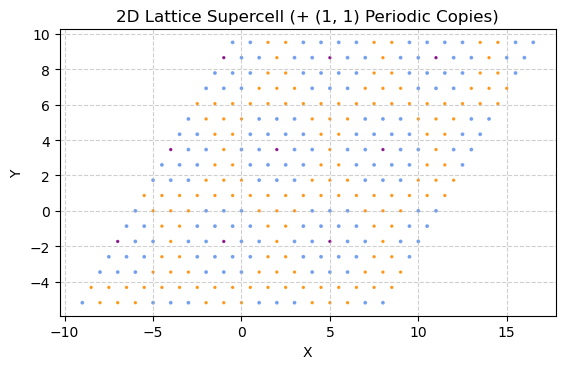

In [163]:
fig = lattice_hex.visualize(site_marker_color=colors, site_marker_size=sizes, show_periodic_copies=True)
display(fig)

In [164]:
lattice_hex._neighbor_cache

{(4,
  2.1): (array([ 0,  2,  3,  5,  8,  9, 10, 11, 14, 15, 16, 24, 28, 29, 30, 33, 34,
         35]), array([2.        , 2.        , 1.        , 1.        , 1.73205081,
         1.        , 1.        , 1.73205081, 2.        , 1.73205081,
         2.        , 2.        , 2.        , 1.73205081, 1.73205081,
         1.73205081, 1.        , 1.        ]))}

In [150]:
dist

array([2.        , 2.        , 1.        , 1.        , 1.73205081,
       1.        , 1.        , 1.73205081, 2.        , 1.73205081,
       2.        , 2.        , 2.        , 1.73205081, 1.73205081,
       1.73205081, 1.        , 1.        ])

In [151]:
nbs

array([ 0,  2,  3,  5,  8,  9, 10, 11, 14, 15, 16, 24, 28, 29, 30, 33, 34,
       35])

In [114]:
len(lattice_hex)

36